## Class Activation Mapping

In [1]:
!pip install jupyterthemes

from jupyterthemes import jtplot
# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('monokai')
jtplot.figsize(aspect=4)

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch.nn.functional as F
from torch import topk
import numpy as np
import skimage.transform
import torch

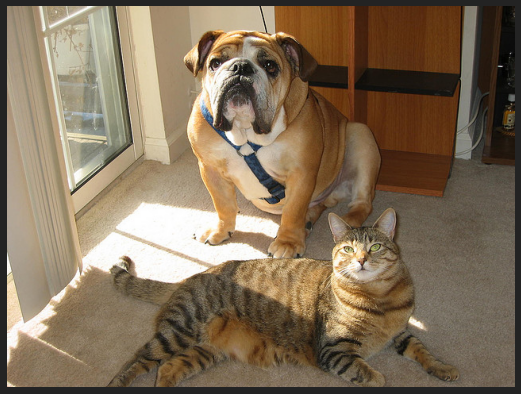

In [2]:
image = Image.open("both.png").convert("RGB")
imshow(image)
plt.axis("off")
plt.show()

## Preprocessing

In [3]:
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

input_img = preprocess(image)
input_img.shape

torch.Size([3, 224, 224])

In [4]:
model = models.resnet18(pretrained=True).eval()

In [5]:
## hook class 선언
class Hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_fn)    
        
    def hook_fn(self, module, input, output):
        self.features = output.cpu().detach().numpy()
        
    def remove(self): 
        self.hook.remove()

In [6]:
print(model)
final_layer = model.layer4
# print(final_layer)
hook = Hook(final_layer) # layer 4에대해서만 hook을 걸어줍니다

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
## forward image
prediction = model(input_img.unsqueeze(0)) # batch화를 해주기 위해서 dim = 0에 대해 unsqueeze
print(prediction.shape)
print(hook.features.shape)
hook.remove() # 걸어준 hook 지우기

torch.Size([1, 1000])
(1, 512, 7, 7)


In [8]:
pred_probabilities = F.softmax(prediction, dim = 1) # prediction 값의 1번째 dim에 대해 softmax취해줌 (model output은 softmax가 안취해져있음)
pred_probabilities = pred_probabilities.squeeze() # [1000]

In [9]:
topk(pred_probabilities,1) # return 값으로 topk에 해당하는 value와 indices가 나옵니다.

torch.return_types.topk(
values=tensor([0.4216], grad_fn=<TopkBackward0>),
indices=tensor([243]))

## TO DO : get cam

In [10]:
##implement CAM
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape # 512, 7, 7
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w))) # 512 * [512, 7*7] -> [7*7]
    import pdb; pdb.set_trace()
    cam = cam.reshape(h, w) #[7, 7]
    cam = cam - np.min(cam) # positive
    cam_img = cam / np.max(cam) # max -> 0 - 1사이 값으로 정규화
    return [cam_img]

In [11]:
weight_softmax_params = list(model.fc.parameters())
len(weight_softmax_params) # weight_softmax_params[0]에는 nn.linear의 weight이, weight_softmax_params[1]에는 bias가 저장. 

2

In [12]:
weight_softmax = weight_softmax_params[0].cpu().detach().numpy() # weight 만 쓸 것임
weight_softmax.shape

(1000, 512)

In [13]:
topk_values, topk_idx = topk(pred_probabilities, 10) #top10개 뽑아서 그 indices정보를 가져옴
topk_idx = topk_idx[0] #top1 index를 저장
topk_idx

tensor(243)

In [14]:
overlay = getCAM(hook.features, weight_softmax, topk_idx) #top1 index에 대해서 CAM 구함.

> <ipython-input-10-f3b0f0877a0e>(6)getCAM()
      4     cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
      5     import pdb; pdb.set_trace()
----> 6     cam = cam.reshape(h, w)
      7     cam = cam - np.min(cam)
      8     cam_img = cam / np.max(cam)



ipdb>  cam.shape


(49,)


ipdb>  q


BdbQuit: 

In [ ]:
print(len(overlay))
overlay[0].shape

In [ ]:
imshow(overlay[0], alpha=0.5, cmap='jet')
plt.show()

In [ ]:
with open("imagenet1000_clsid_to_human.txt") as f:
    idx2label = eval(f.read())

In [ ]:
idx2label

In [ ]:
print(topk_idx)
print(idx2label[int(topk_idx)])

In [ ]:
display_transform = transforms.Compose([transforms.Resize((224,224))])
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], (224, 224), mode='constant'), alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()